In [77]:
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from enigma.enigma import Enigma
from enigma.rotors.rotor_with_mapping_and_notches import RotorWithMappingAndNotches
from enigma.rotors.rotor_I import RotorI
from enigma.rotors.rotor_II import RotorII
from enigma.rotors.rotor_III import RotorIII
from enigma.rotors.rotor_IV import RotorIV
from enigma.rotors.rotor_V import RotorV
from enigma.reflectors.reflector_b import ReflectorB
from enigma.plugboard import Plugboard
from language_models.character_frequency_kld_language_model import CharacterFrequencyKLDLanguageModel
from language_models.character_frequency_ic_language_model import CharacterFrequencyICLanguageModel
from language_models.markov_chain_model import MarkovChainModel

import random
from collections import OrderedDict
import heapq
from itertools import permutations, combinations
from tqdm import tqdm
from tqdm.auto import trange
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import re
from Levenshtein import distance

In [78]:
POSSIBLE_ROTORS = {RotorI, RotorII, RotorIII, RotorIV, RotorV}
POSSIBLE_LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def config_to_string(rotors_classes, offsets, ringstellungs, plugboard_tuples):
    string = ""
    for rot, off, rs in zip(rotors_classes, offsets, ringstellungs):
        string += rot.__name__+"(o:%d,rs:%d)"%(off,rs)+"|"
    for l1, l2 in plugboard_tuples:
        string += l1+l2
    return string

def get_random_plugboad(plugboard_size: int):
    letter_sample = random.sample(list(POSSIBLE_LETTERS), plugboard_size*2)
    plugboard_tuples = []
    for i in range(len(letter_sample)//2):
        plugboard_tuples.append((letter_sample[i*2], letter_sample[(i*2)+1]))
    plugboard_tuples = sorted(plugboard_tuples, key=lambda x: x[0])
    return plugboard_tuples

def get_random_config(plugboard_size: int):
    rotors_to_use = random.sample(POSSIBLE_ROTORS, 3)
    offsets = [random.randint(0,25) for _ in range(3)]
    ringstellungs = [random.randint(0,25) for _ in range(3)]
    plugboard_tuples = get_random_plugboad(plugboard_size)
    return rotors_to_use, offsets, ringstellungs, plugboard_tuples

def transform_to_valid_chars(text: str):
    text = text.upper()
    return "".join([c for c in text if c in POSSIBLE_LETTERS])

def string_to_config(string: str):
    match = re.findall("(.+)\(o:(\d+),rs:(\d+)\)\|(.+)\(o:(\d+),rs:(\d+)\)\|(.+)\(o:(\d+),rs:(\d+)\)\|(.*)", 
                       string, re.IGNORECASE)[0]
    available_rotors = {rot.__name__:rot for rot in RotorWithMappingAndNotches.__subclasses__()}
    rotors_classes = [available_rotors[match[0]], available_rotors[match[3]], available_rotors[match[6]]]
    offsets = [int(match[1]), int(match[4]), int(match[7])]
    ringstellungs = [int(match[2]), int(match[5]), int(match[8])]
    plugboard_tuples = []
    for i in range(len(match[9])//2):
        plugboard_tuples.append((match[9][i*2],match[9][(i*2)+1]))
    return rotors_classes, offsets, ringstellungs, plugboard_tuples

In [2]:
runs = []
for filename in tqdm([fn for fn in os.listdir('serialized_runs') if '.pickle' in fn]):
    with open('serialized_runs/%s' % filename, "rb") as run_file:
        random_config_key, random_text_test, cyphertext, scores, ringstellung_scores, final_scores, final_best = (None, *pickle.load(run_file))
        keys_to_keep = set([c for c,s in sorted([(c,s['IC']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        keys_to_keep.update([c for c,s in sorted([(c,s['KLD']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        keys_to_keep.update([c for c,s in sorted([(c,s['Markov']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        scores = {k:v for k,v in scores.items() if k in keys_to_keep}
        runs.append((int(filename.split('_')[0]),random_config_key, random_text_test, cyphertext, scores, ringstellung_scores, final_scores, final_best))
for filename in tqdm([fn for fn in os.listdir('serialized_runs2') if '.pickle' in fn]):
    with open('serialized_runs2/%s' % filename, "rb") as run_file:
        random_config_key, random_text_test, cyphertext, scores, ringstellung_scores, final_scores, final_best = pickle.load(run_file)
        keys_to_keep = set([c for c,s in sorted([(c,s['IC']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        keys_to_keep.update([c for c,s in sorted([(c,s['KLD']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        keys_to_keep.update([c for c,s in sorted([(c,s['Markov']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)[:5000]])
        scores = {k:v for k,v in scores.items() if k in keys_to_keep}
        runs.append((int(filename.split('_')[0]),random_config_key, random_text_test, cyphertext, scores, ringstellung_scores, final_scores, final_best))

100%|██████████| 50/50 [14:12<00:00, 17.05s/it]


In [31]:
outcomes_by_plugboard = {}
for r in runs:
    plug_size = r[0]
    if plug_size not in outcomes_by_plugboard:
        outcomes_by_plugboard[plug_size] = []
    outcomes_by_plugboard[plug_size].append(r[-1][-1])

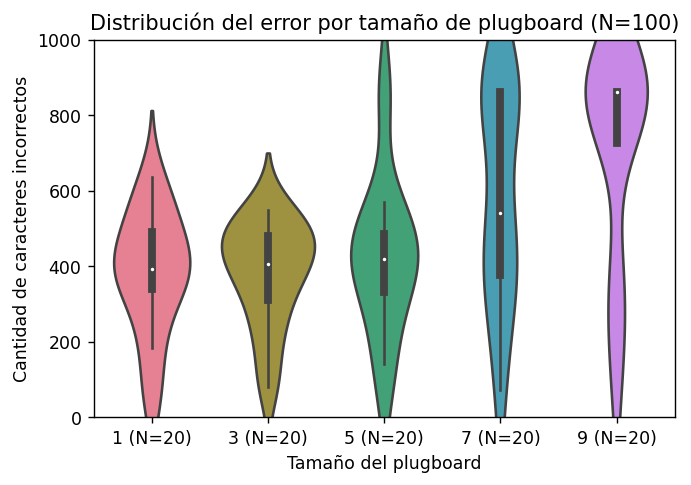

In [94]:
plt.figure(dpi=125)
ax = sns.violinplot(data=[l for _,l in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Distribución del error por tamaño de plugboard (N=100)")
ax.set_xticklabels(["%d (N=20)"%p for p,_ in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])])
plt.ylim((0,1000))
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Cantidad de caracteres incorrectos")
plt.savefig("final_figs/error_dist.jpg")
plt.show()

/home/jian01/.pyenv/versions/3.6.9/envs/cripto_tp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


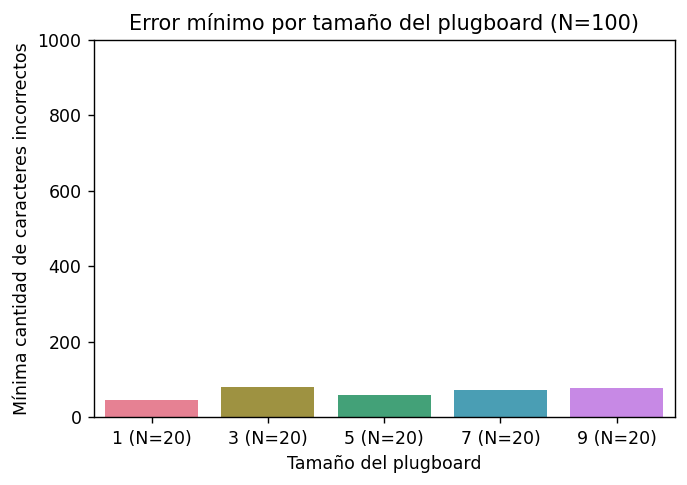

In [96]:
plt.figure(dpi=125)
sns.barplot(["%d (N=20)"%p for p,_ in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])],
                  [min(l) for _,l in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Error mínimo por tamaño del plugboard (N=100)")
plt.ylim((0,1000))
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Mínima cantidad de caracteres incorrectos")
plt.savefig("final_figs/min_error.jpg")
plt.show()

/home/jian01/.pyenv/versions/3.6.9/envs/cripto_tp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


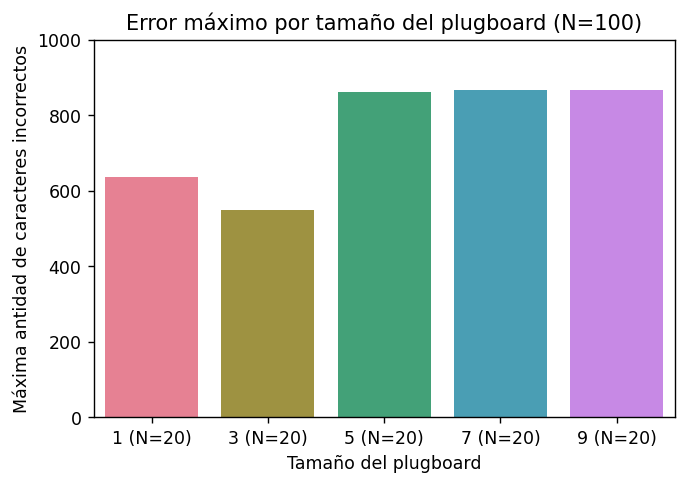

In [98]:
plt.figure(dpi=125)
sns.barplot(["%d (N=20)"%p for p,_ in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])],
                  [max(l) for _,l in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Error máximo por tamaño del plugboard (N=100)")
plt.ylim((0,1000))
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Máxima antidad de caracteres incorrectos")
plt.savefig("final_figs/max_error.jpg")
plt.show()

/home/jian01/.pyenv/versions/3.6.9/envs/cripto_tp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


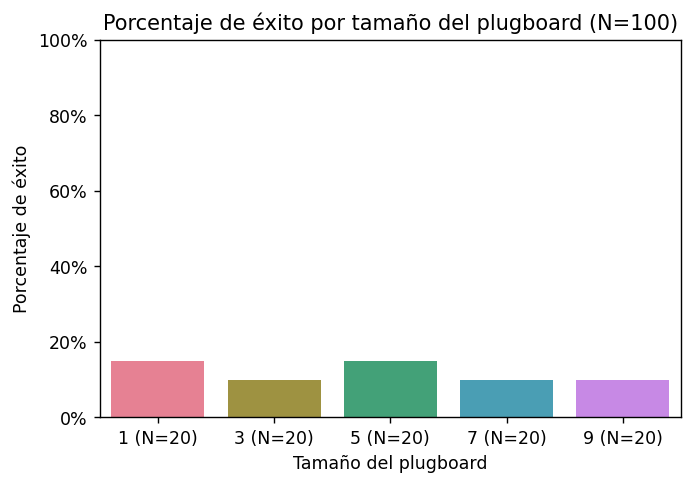

In [99]:
plt.figure(dpi=125)
sns.barplot(["%d (N=20)"%p for p,_ in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])],
                  [np.mean([(1 if r<200 else 0) for r in l])*100 for _,l in sorted(outcomes_by_plugboard.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Porcentaje de éxito por tamaño del plugboard (N=100)")
plt.ylim((0,100))
plt.yticks(list(range(0,101,20)), ["%d"%t + "%" for t in range(0,101,20)])
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Porcentaje de éxito")
plt.savefig("final_figs/success.jpg")
plt.show()

In [81]:
plugboard_is_equal = {}
rotor_order_is_equal = {}
for r in runs:
    if not r[1]:
        continue
    plug_size = r[0]
    original_plugboard = sorted(r[1].split('|')[-1])
    original_rotor_order = string_to_config(r[1])[0]
    found_rotor_order = string_to_config(r[-1][0])[0]
    found_plugboard = sorted(r[-1][0].split('|')[-1])
    if plug_size not in plugboard_is_equal:
        plugboard_is_equal[plug_size] = []
    if plug_size not in rotor_order_is_equal:
        rotor_order_is_equal[plug_size] = []
    plugboard_is_equal[plug_size].append(found_plugboard==original_plugboard)
    rotor_order_is_equal[plug_size].append(found_rotor_order==original_rotor_order)

/home/jian01/.pyenv/versions/3.6.9/envs/cripto_tp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


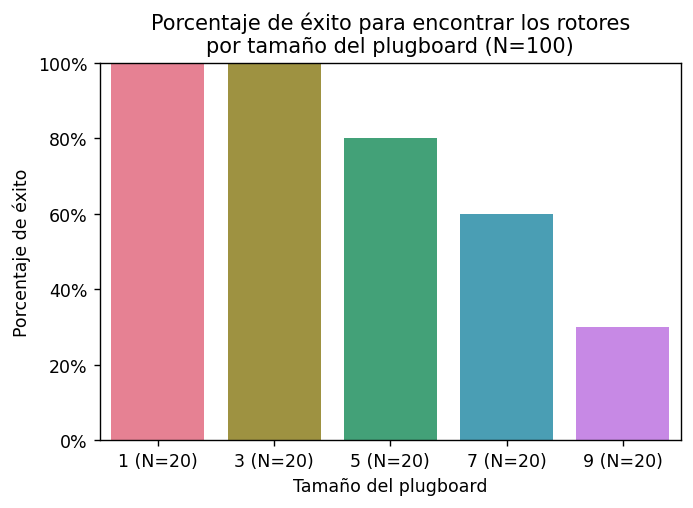

In [102]:
plt.figure(dpi=125)
sns.barplot(["%d (N=20)"%p for p,_ in sorted(rotor_order_is_equal.items(), key=lambda x:x[0])],
                  [np.mean(l)*100 for _,l in sorted(rotor_order_is_equal.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Porcentaje de éxito para encontrar los rotores\npor tamaño del plugboard (N=100)")
plt.ylim((0,100))
plt.yticks(list(range(0,101,20)), ["%d"%t + "%" for t in range(0,101,20)])
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Porcentaje de éxito")
plt.savefig("final_figs/rotor_order_success.jpg")
plt.show()

/home/jian01/.pyenv/versions/3.6.9/envs/cripto_tp/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


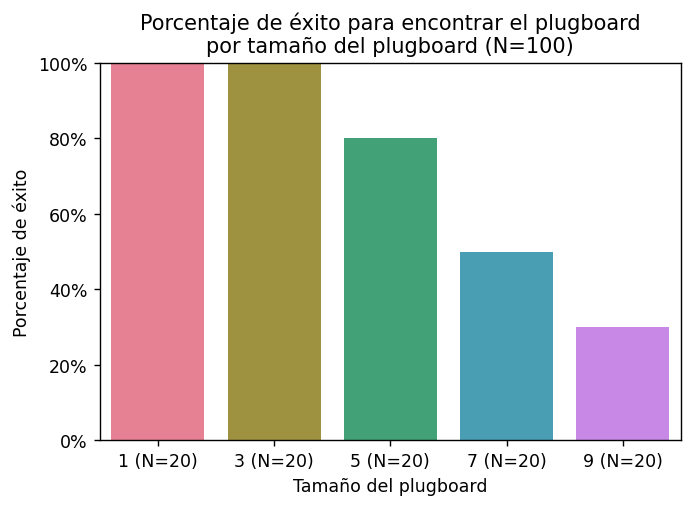

In [101]:
plt.figure(dpi=125)
sns.barplot(["%d (N=20)"%p for p,_ in sorted(plugboard_is_equal.items(), key=lambda x:x[0])],
                  [np.mean(l)*100 for _,l in sorted(plugboard_is_equal.items(), key=lambda x:x[0])], palette=sns.color_palette("husl", 5))
plt.title("Porcentaje de éxito para encontrar el plugboard\npor tamaño del plugboard (N=100)")
plt.ylim((0,100))
plt.yticks(list(range(0,101,20)), ["%d"%t + "%" for t in range(0,101,20)])
plt.xlabel("Tamaño del plugboard")
plt.ylabel("Porcentaje de éxito")
plt.savefig("final_figs/plugboard_success.jpg")
plt.show()